# Analysis of the Breast Cancer Wisconsin dataset

In this notebook, we are using the Breast Cancer Wisconsin dataset to perform a cluster analysis. Originally, the dataset was proposed in order to train classifiers; however, it can be very helpful for a non-trivial cluster analysis. It contains 569 records made up of 32 attributes (including the diagnosis and an identification number). All the attributes are strictly related to biological and morphological properties of the tumors, but our goal is to validate generic hypotheses considering the ground truth (benign or malignant) and the statistical properties of the dataset. Before moving on, it's important to clarify some points. The dataset is high-dimensional and the clusters are non-convex (so we cannot expect a perfect segmentation). Moreover our goal is not using a clustering algorithm to obtain the results of a classifier; therefore, the ground truth must be taken into account only as a generic indication of a potential grouping. The goal of such an example is to show how to perform a brief preliminary analysis, select the optimal number of clusters, and validate the final results.

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import contingency_matrix
from sklearn.datasets import make_blobs

# For reproducibility
np.random.seed(1000)

In [5]:
# Download from: https://archive.ics.uci.edu/mxl/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
# Change <data_folder> with the actual path
bc_dataset_path = 'wdbc.txt'

bc_dataset_columns = ['id','diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
                      'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
                      'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                      'radius_se','texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
                      'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
                      'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
                      'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
                      'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [6]:
# Load the dataset
df = pd.read_csv(bc_dataset_path, index_col=0, names=bc_dataset_columns).fillna(0.0)

# Show the overall statistical properties
print(df.describe())

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

Lets observe the different scales existing among the features, the disparity between standard deviations and values means that some features will have more impact on the clustering than others, one possible solution could be to normalize the values to give equal responsability to the attributes, however, for now lets use the values as they are, since we don't know the biological impact they have in reality and we don't have any indication from an expert in the field.

Lets explore the interaction between a small subset of the features, and then visualize the data using t-SNE.

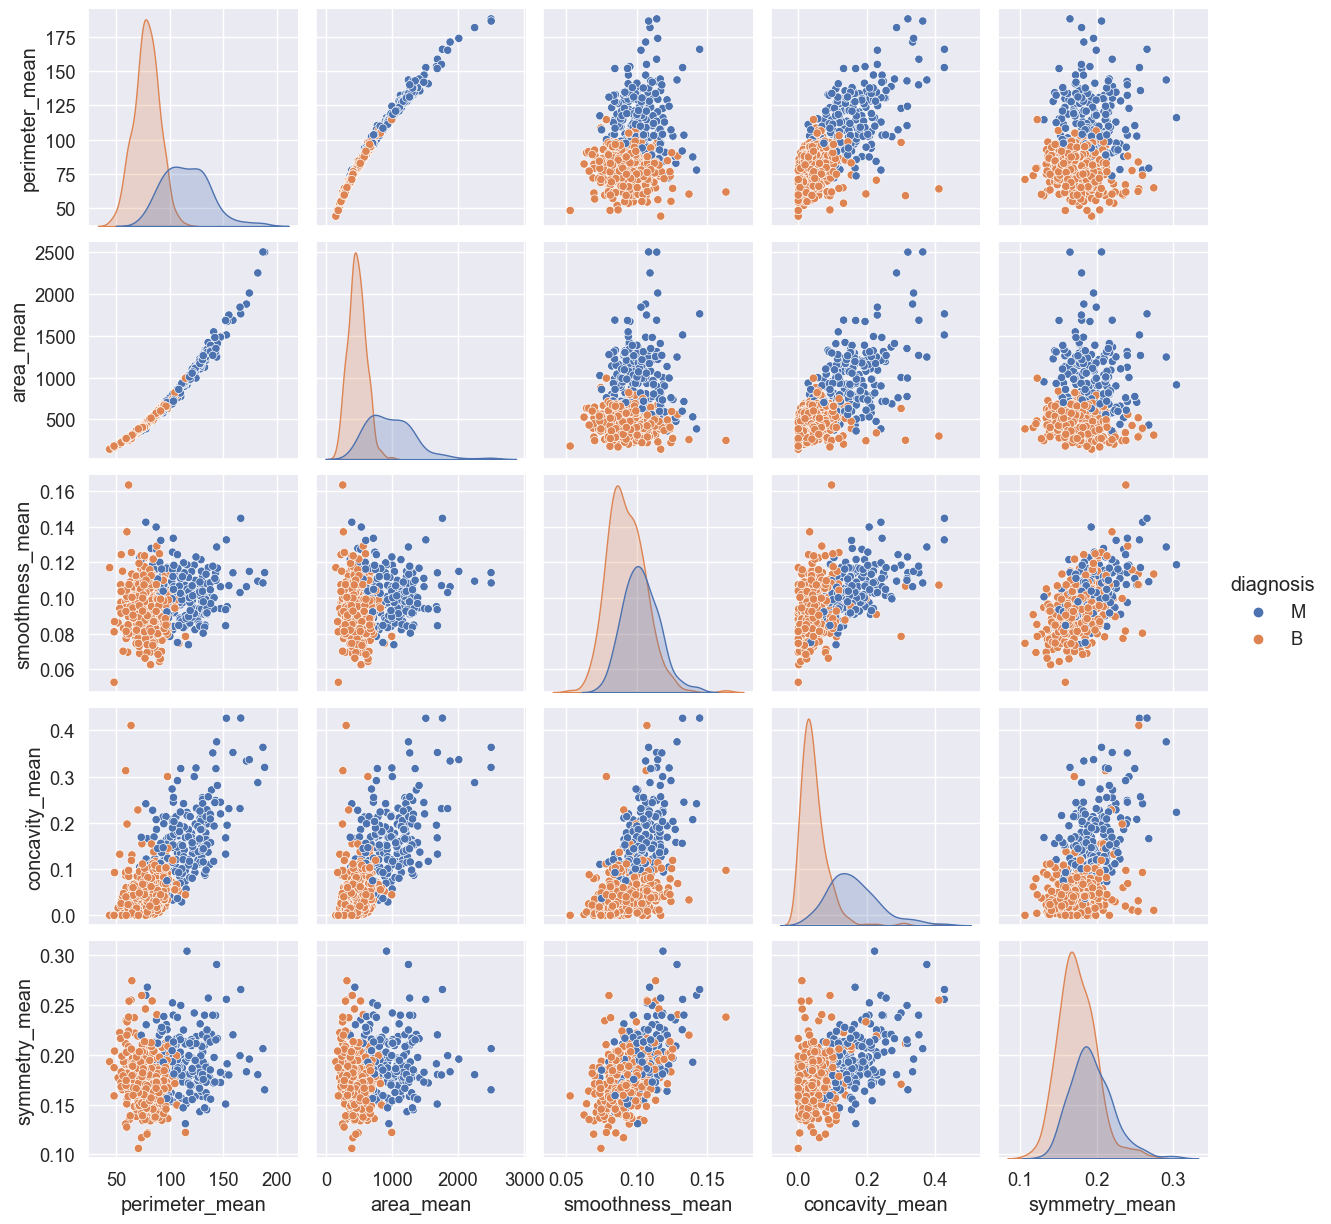

In [7]:
# Show the pair-plot
sns.set()

with sns.plotting_context("notebook", font_scale=1.2):
    sns.pairplot(df,
                 vars=['perimeter_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean'],
                 hue="diagnosis")

plt.show()

c:\Users\hageo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hageo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


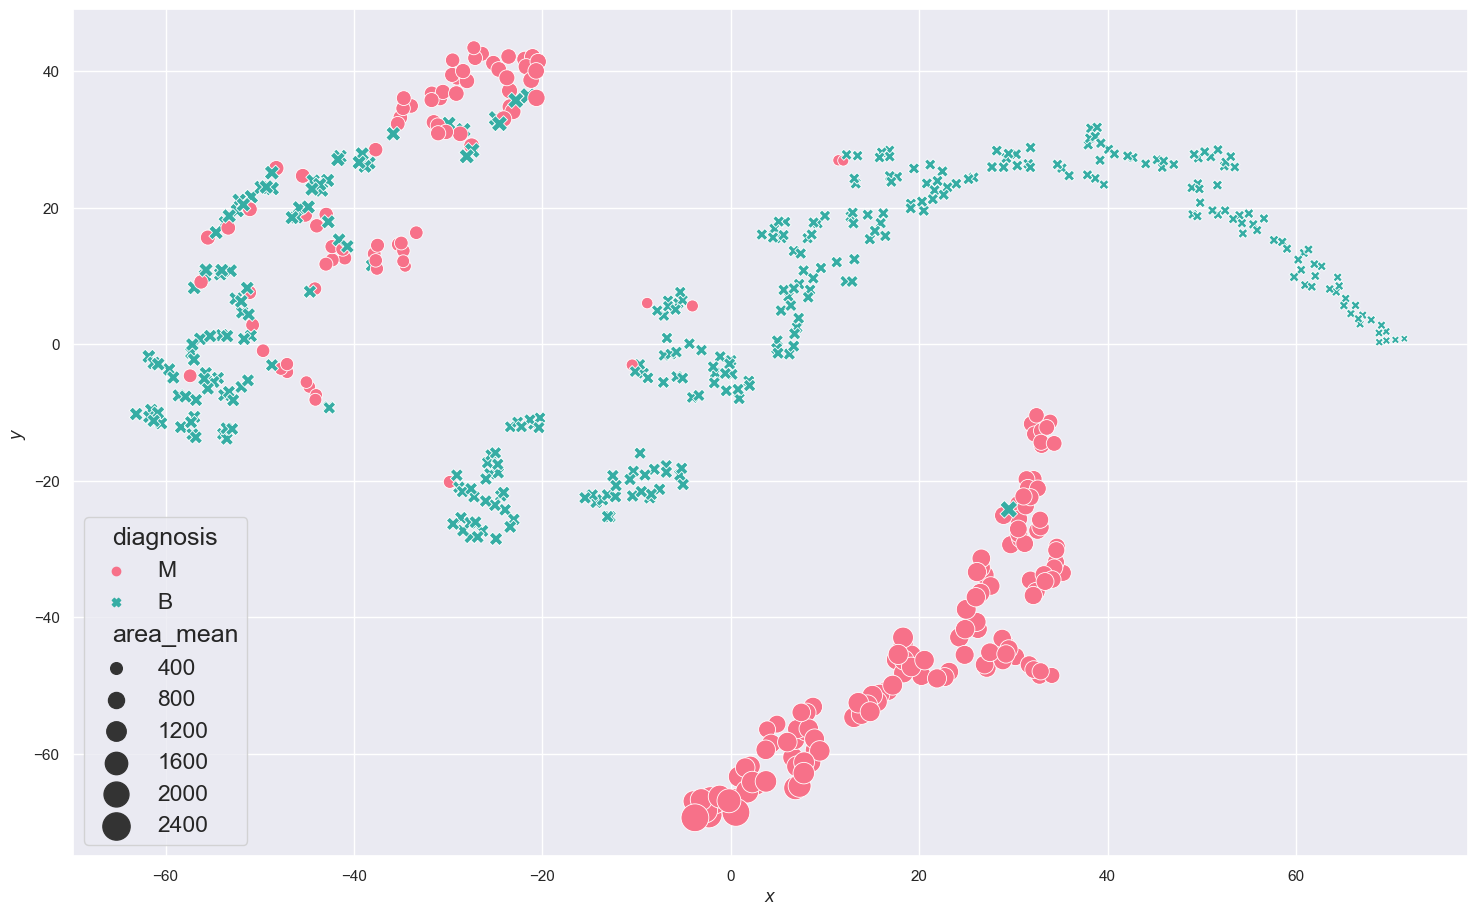

In [8]:
# Project the dataset on a bidimensional plane
cdf = df.drop(['diagnosis'], axis=1)

tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(cdf)

df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=cdf.index)
dff = pd.concat([df, df_tsne], axis=1)

# Show the diagram
fig, ax = plt.subplots(figsize=(18, 11))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='x',
                    y='y',
                    hue='diagnosis',
                    size='area_mean',
                    style='diagnosis',
                    sizes=(30, 400),
                    palette=sns.color_palette("husl", 2),
                    data=dff,
                    ax=ax)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.show()

The diagram is highly non-linear (don't forget this is a projection to 2-D made by t-SNE), but the majority of the malign samples are on one side of the plane $x>0$. Unfortunately, also a moderate percentage of benign samples are in this section, hence we don't expect a perfect separation using $K=2$. Lets try that with K-means.

In [9]:
# Perform a K-Means clustering with K=2
km = KMeans(n_clusters=2, max_iter=1000, random_state=1000, n_init=10)
Y_pred = km.fit_predict(cdf)

df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
kmdff = pd.concat([dff, df_km], axis=1)

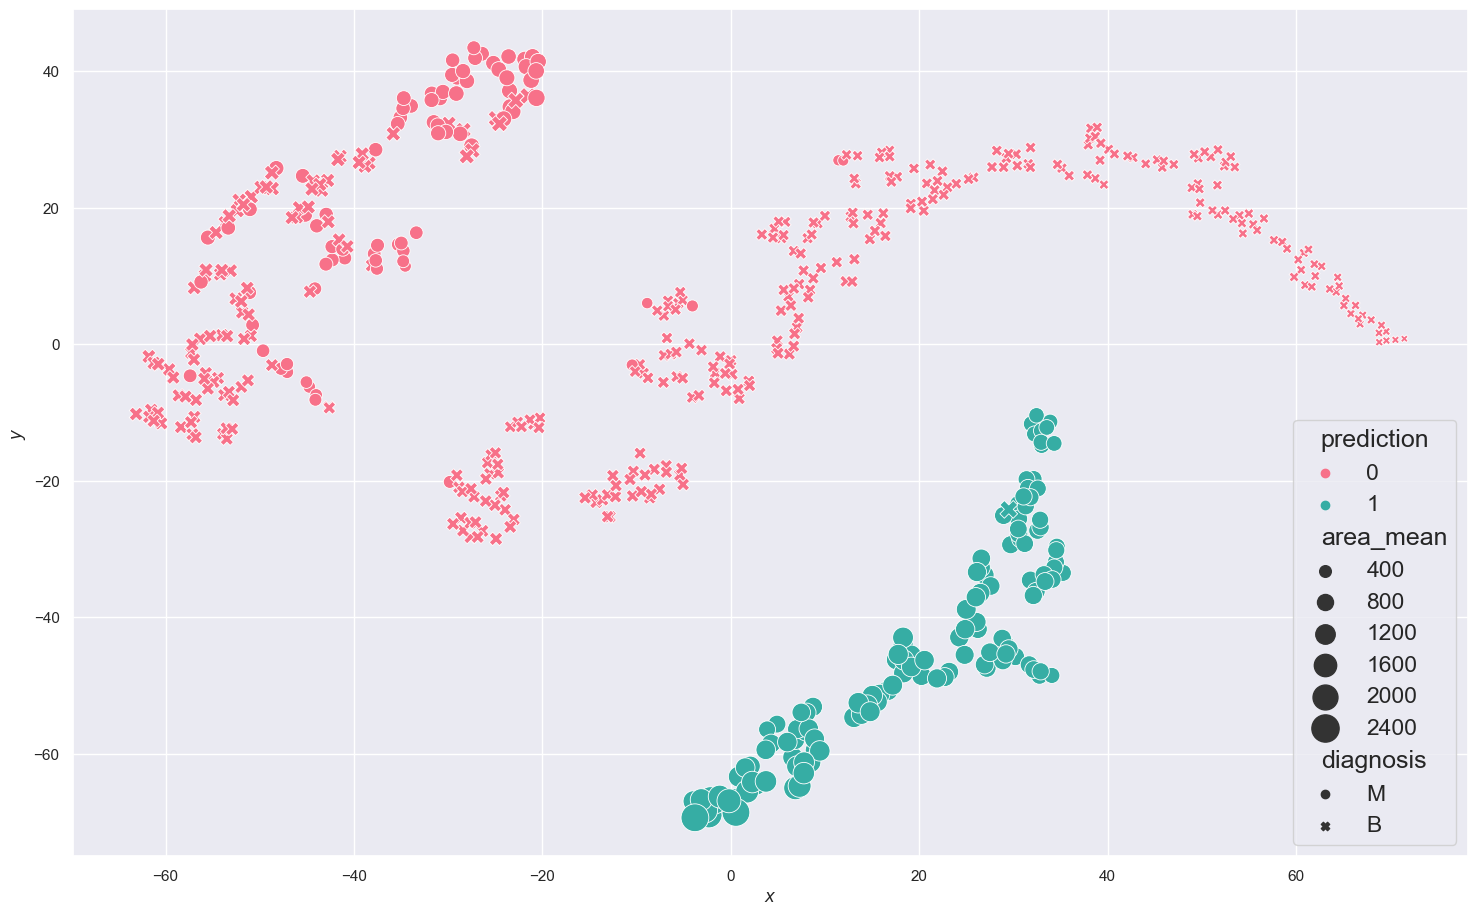

In [10]:
# Show the clustering result
fig, ax = plt.subplots(figsize=(18, 11))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='x',
                    y='y',
                    hue='prediction',
                    size='area_mean',
                    style='diagnosis',
                    sizes=(30, 400),
                    palette=sns.color_palette("husl", 2),
                    data=kmdff,
                    ax=ax)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.show()

We can see the algorithm have trouble at the boundary points, this is due to the non-convexity of the original dataset. But how can we measure how good are the resultant clusters?

## Evaluation Metrics

In this section, we are going to analyze some common methods that can be employed to evaluate the performance of a clustering algorithm and also to help find the optimal number of clusters.

### Minimizing the inertia

One of the biggest drawbacks of K-means is the explicit request for the number of clusters. Sometimes this is imposed by external constraints (for example, in the example of breast cancer, there are only two possible diagnoses), but in many cases (when an exploratory analysis is needed), the data scientist has to check different configurations and evaluate them. The simplest way to evaluate K-means performance and choose an appropriate number of clusters is based on the comparison of different final inertias.

Lets start with a simpler example with 12 generated blobs.

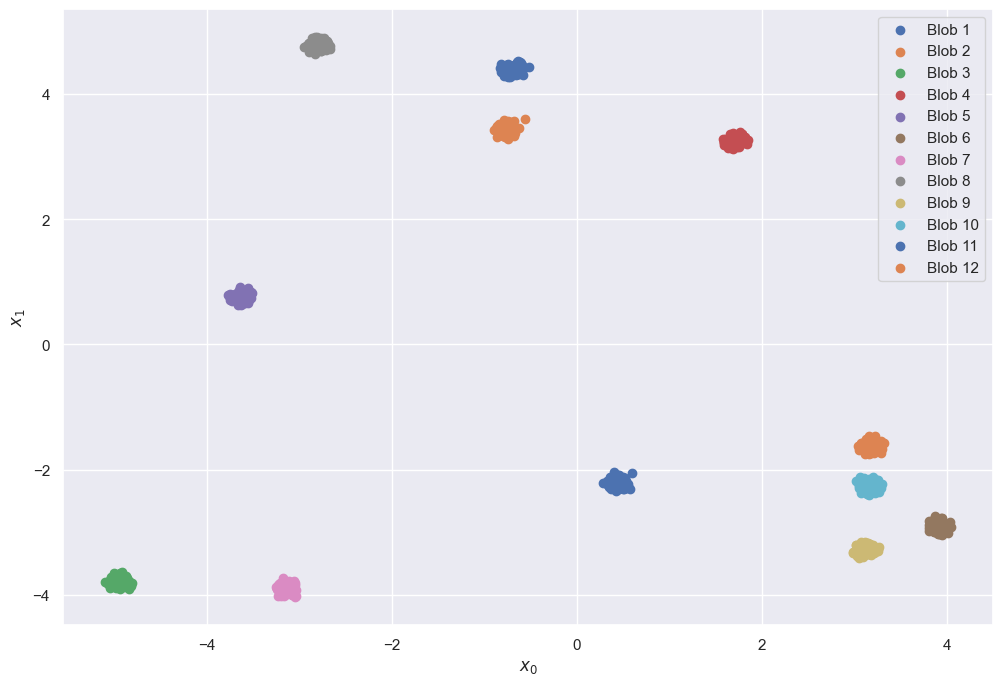

In [11]:
X, Y = make_blobs(n_samples=2000, n_features=2, centers=12,
                  cluster_std=0.05, center_box=[-5, 5], random_state=100)

# Show the blobs
sns.set()

fig, ax = plt.subplots(figsize=(12, 8))

for i in range(12):
    ax.scatter(X[Y == i, 0], X[Y == i, 1], label='Blob {}'.format(i + 1))

ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.legend()

plt.show()

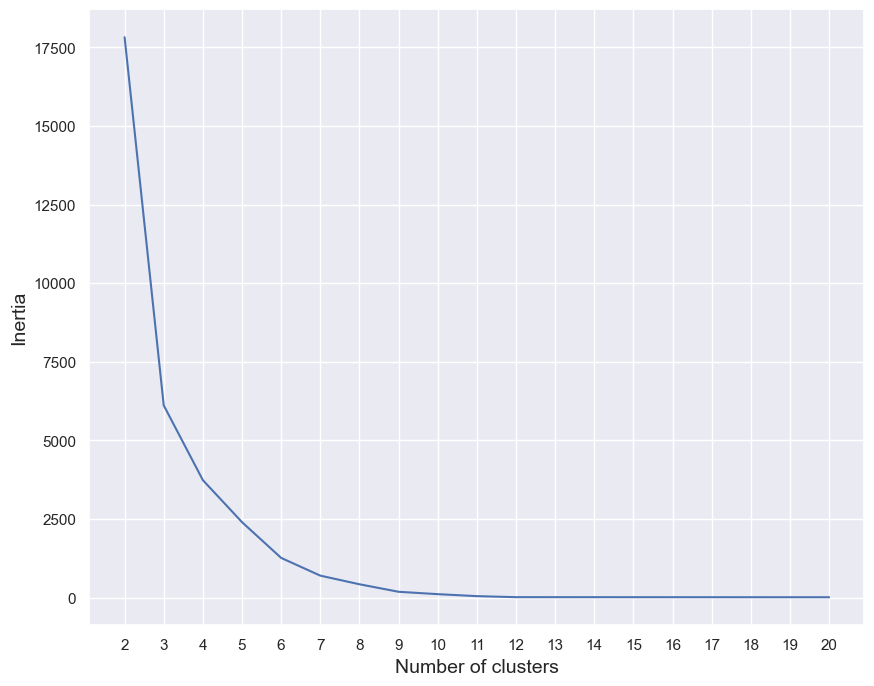

In [12]:
# Compute the inertia
inertias = []

for i in range(2, 21):
    km = KMeans(n_clusters=i, max_iter=1000, random_state=1000)
    km.fit(X)
    inertias.append(km.inertia_)

# Show the plot inertia vs. no. clusters
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(2, 21, 1), inertias)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Inertia', fontsize=14)
ax.set_xticks(np.arange(2, 21, 1))

plt.show()

This is a common behavior, when the number of clusters is very small the density is proportionally low, hence the cohesion is low and, as a result, the inertia is high. Increasing the number of clusters forces the model to create more cohesive groups and the inertia starts to decrease abruptly. If we continue this process and M >> K, we will observe a very slow approach toward the value corresponding to a configuration where K=M (each sample is a cluster).

The general rule is to use the "elbow" method (when there are not external constraints) to decide the number of clusters for maximum cohesion without internal fragmentation. In this case if we go for K=15, nine blobs would have been identified as a cluster and the other three would be splited in two parts, which reduce the inertia, but the principle of maximum separation is not followed anymore.

Lets repeat the experiment with the Breast Cancer dataset from 2 to 50 clusters.

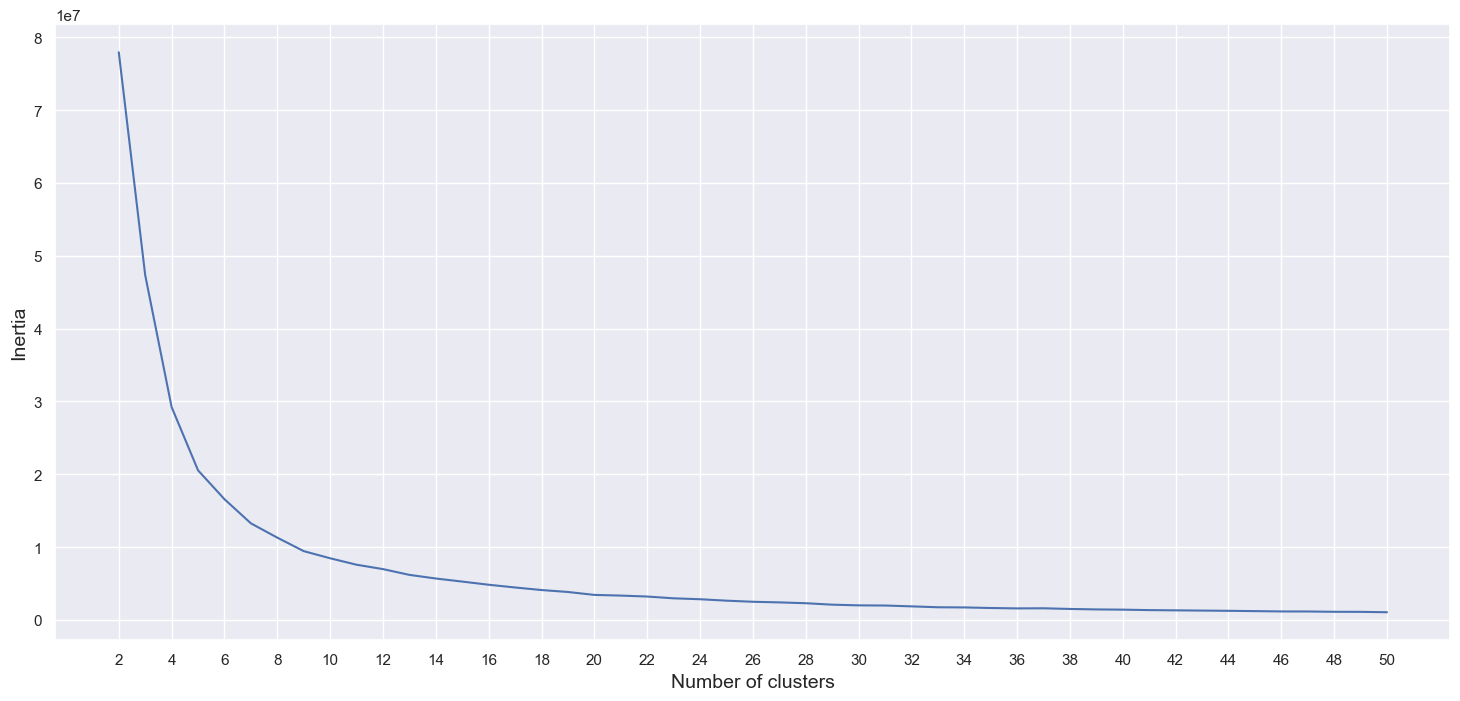

In [13]:
# Compute the inertia
inertias = []

for i in range(2, 51):
    km = KMeans(n_clusters=i, max_iter=1000, random_state=1000, n_init=10)
    km.fit(cdf)
    inertias.append(km.inertia_)

# Show the plot inertia vs. no. clusters
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(np.arange(2, 51, 1), inertias)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Inertia', fontsize=14)
ax.set_xticks(np.arange(2, 51, 2))

plt.show()


### Silhoutte score

The most common method to assess the performance of a clustering algorithm without knowledge of the ground truth is the silhouette score. It provides both a per-sample index and a global graphical representation that shows the level of internal coherence and separation of the clusters. In order to compute the score, we need to introduce two auxiliary measures.

The first one is the average intra-cluster distance of a sample $x^{(i)} \in C_I$ assuming the cardinality of the cluster $C_I$ to be $|C_I|$:

$$ a(x^{(i)}) = \frac{1}{\left| C_I \right| - 1} \sum_{x^{(j)} \in C_J, i \neq j} d(x^{(i)}, x^{(j)})$$

We can interpret $a(x^{(i)})$ as a measure of how well $x^{(i)}$ is assigned to its cluster (the smaller the value, the better).

The distance can be assumed to be Euclidean, but there are no specific limitations on that, so we could use a different metric.

We then define the mean distance of point $x^{(i)}$ to some cluster $C_J$ as the mean of the distance from $x^{(i)}$ to all points in $C_J$ where $C_J \neq C_I$.

Then, we have:

$$ b(x^{(i)}) = \min_{J \neq I} \frac{1}{\left| C_J \right|} \sum_{x^{(j)} \in C_J} d(x^{(i)}, x^{(j)}) $$

With these two measures, we can define the Silhouette score for x^{(i)} as:

$$ s(x^{(i)}) = \frac{b(x^{(i)}) - a(x^{(i)})}{\max \left( a(x^{(i)}), b(x^{(i)}) \right)}$$

The score $s(x^{(i)}) \in (-1,1)$.

When $s(x^{(i)}) \rightarrow -1$ it means $b(x^{(i)}) << a(x^{(i)})$, hence the sample $x^{(i)} \in C_I$ is closer to the nearest cluster $C_J$ than to the other samples asigned to its cluster $C_I$, which indicates a wrong assignment.

Conversely, when $s(x^{(i)}) \rightarrow 1$ then $b(x^{(i)}) >> a(x^{(i)})$, so the sample is more closer to its neighbors than any other point assigned to the nearest cluster, so this is a good assignment.

Since this index is not global, we introduce the Silhouette plots which shows the scores achieved by each sample, grouped by cluster and sorted in descending order.

Lets do that for the Breast Cancer dataset with $K={2,4,6,8}$.

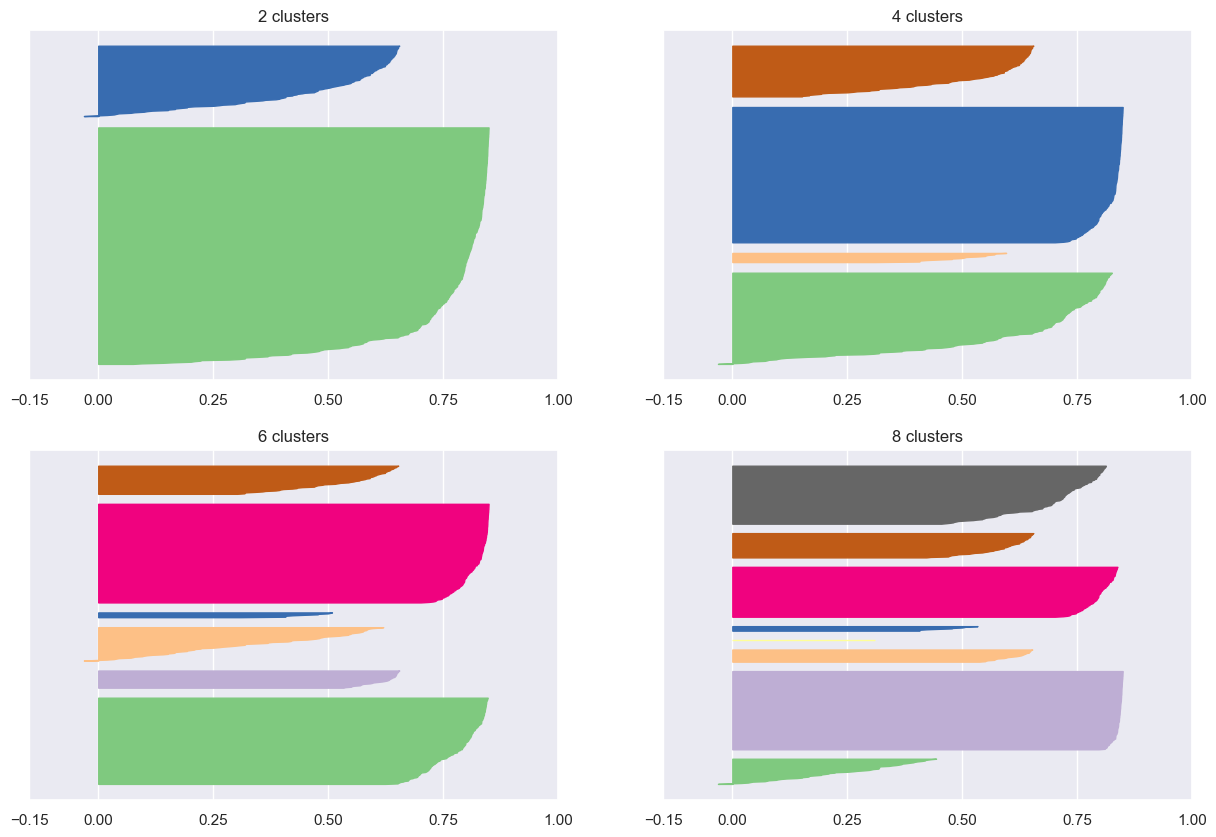

In [14]:
nb_clusters = [2, 4, 6, 8]
mapping = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Show the silhouette plots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, n in enumerate(nb_clusters):
    km = KMeans(n_clusters=n, random_state=1000)
    Y = km.fit_predict(cdf)
    df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
    kmdff = pd.concat([dff, df_km], axis=1)

    silhouette_values = silhouette_samples(cdf, kmdff['prediction'])

    ax[mapping[i]].set_xticks([-0.15, 0.0, 0.25, 0.5, 0.75, 1.0])
    ax[mapping[i]].set_yticks([])
    ax[mapping[i]].set_title('%d clusters' % n)
    ax[mapping[i]].set_xlim([-0.15, 1])
    y_lower = 20

    for t in range(n):
        ct_values = silhouette_values[Y == t]
        ct_values.sort()

        y_upper = y_lower + ct_values.shape[0]

        color = cm.Accent(float(t) / n)
        ax[mapping[i]].fill_betweenx(np.arange(y_lower, y_upper), 0, ct_values, facecolor=color, edgecolor=color)

        y_lower = y_upper + 20

plt.show()

## Rand Index

The Rand Index (RI) is a measure of similarity between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters. It can be use to evaluate a clustering against the ground truth class assignments, if they are available.

The raw RI score is:

$$ RI = \frac{\text{number of agreeing pairs}}{\text{number of pairs}} $$

If we consider two different clustering partitions $X$ and $Y$, then we can define the possible assignment of a pair as follows:

- a: number of pairs that are in the same cluster in $X$ and in the same cluster in $Y$.
- b: number of pairs that are in different clusters in $X$ and in different clusters in $Y$.
- c: number of pairs that are in the same cluster in $X$ and in different clusters in $Y$.
- d: number of pairs that are in different clusters in $X$ and in the same cluster in $Y$.

In those terms the Rand Index can be expressed as follows:

$$ RI = \frac{a+b}{a+b+c+d} $$

The total number of pairs is the number of combinations of the $m$ elements of the dataset into two:

$$a+b+c+d = {m \choose 2} = \frac{m(m-1)}{2}$$

RI has a value in the range [0,1], with 0 indicating the two data clusterings do not agree on any pair of points and 1 indicating the data clusterings are exactly the same.

**SIDE QUESTION:** Do the RI formulation above in terms of a, b, c, and d reminds you of some classification metric?

## Fowlkes-Mallows

The Fowlkes Mallows index can be used when the ground truth class assignments are known. It is defined as the geometric mean between the precision and recall, so it ranges from 0 to 1, with a high value indicating good similarity between two clusters.

Considering $X$ as the true clustering partition and $Y$ as the predicted clustering partition we can define the following:

- TP = number of pairs that are in the same cluster in $X$ and in the same cluster in $Y$.
- TN = number of pairs that are in different clusters in $X$ and in different clusters in $Y$.
- FN = number of pairs that are in the same cluster in $X$ and in different clusters in $Y$.
- FP = number of pairs that are in different clusters in $X$ and in the same cluster in $Y$.

$$FMI = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}}$$

## Mutual Information

The Mutual Information (MI) is a function that measures the agreements of two clustering assignments, so we can use it to compare the result of a clustering algorithm with the true clustering assignment, if available.

Assume two label assignments $X$ and $Y$ of the same $m$ objects. In this formulation $\left| X \right|$ is the number of clusters in the partition $X$ and simlarly for $Y$.

The entropy of the partition $X$ is the amount of uncertainty on the partition (similarly for $Y$), defined by:

$$ H(X) = -\sum_{i=1}^{\left| X \right|} P(i) log(P(i))$$

where $P(i) = \frac{\left| X_i \right|}{m}$ is the probability that an object picked at random from $X$ falls into class $X_i$, likewise for $Y$.

Then the Mutual Information between $X$ and $Y$ is:

$$ MI(X, Y) = \sum_{i=1}^{\left| X \right|} \sum_{j=1}^{\left| Y \right|} P(i,j) \log \left( \frac{P(i,j)}{P_X(i)P_Y(j)} \right) $$

where $P(i,j) = \frac{\left| X_i \cap Y_j \right|}{m}$ is the probability that an object picked at random falls into both classes $X_i$ and $Y_j$.

The Normalized Mutual Information (NMI) is defined as:

$$ NMI(X,Y) = \frac{MI(X,Y)}{mean\left( H(X), H(Y) \right)} $$

The *mean* in the denominator emphasized the fact that some different ways to computing can be used (i.e, geometric, arithmetic, max, min, etc.)

The value of MI and NMI is not adjusted for chance, so it will tend to increase as the number of clusters increases, regardless of the actual amount of "mutual information" between the clusterings.

## Homogeneity, Completeness and V-measure

Given the knowledge of the ground truth class assignments of the samples, we can define some intuitive metric using conditional entropy analysis.

- Homogeneity: each cluster contains only members of a single class.
- Completeness: all members of a given class are assigned to the same cluster.

$$ h = 1 - \frac{H(C | K)}{H(C)} $$

$$ c = 1 - \frac{H(K | C)}{H(K)} $$

where $H(C|K)$ is the conditional entropy of the classes given the cluster assignments, given by:

$$ H(C|K) = -\sum_{c=1}^{\left| C \right|} \sum_{k=1}^{\left| K \right|} \frac{m_{c,k}}{m} \log \left( \frac{m_{c,k}}{m_k} \right)  $$

with $m$ as the total number of samples, $m_c$ and $m_k$ the number of samples belonging to class $c$ and cluster $k$, and $m_{c,k}$ the number of samples from class $c$ assigned to cluster $k$.

We can use Homogeneity and Completeness as independent measures of clustering depending on what property we are interested on, or we can use a combination of both known as V-measure:

$$ v = \frac{(1+\beta) h  c}{\beta h + c} $$

The $\beta$ default value is 1, but we can give more weight to homogeneity by using $\beta < 1$ or to completeness with $\beta > 1$.

## Davies-Bouldin

For the previous clustering evaluation metrics (excepting Silhouette), the ground truth labels must be known, another metric that can be used when the ground truth is unknown is the Davies-Bouldin (DB) index.

DB represents the average similarity between clusters, taking into considerarion the size of the clusters themselves. The lower score the better with 0 being the minimum (best partition).

The index is defined as the average similarity between each cluster $C_i$ and its most similar one $C_j$. In this context, similarity is defined as a measure $R_{ij}$ that trades off:

- $s_i$: the average distance between each point of cluster $i$ and the centroid of that cluster (cluster diameter).
- $d_{ij}$: the distance between the cluster centroid $i$ and $j$.

A common choice is using:

$$R_{ij} = \frac{s_i + s_j}{d_{ij}}$$

Then with this formulation and having $k$ clusters we get the following:

$$ DB = \frac{1}{k} \sum_{i=1}^k \max_{i \neq j} R_{ij}$$

This computation is simpler than Silhouette scores, but the usage of centroid distance limits the metric to Euclidian spaces.

## Exercise

Compute the clustering evaluation metrics described above to the results produced by K-means with the Breast Cancer dataset and different $k={2,4,6,8}$. First, use sklearn functions (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) and then implement the metrics from scratch and compare your results.